[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Example 11.44

Analysis of a dataset consisting of real movie ratings, our goal is to estimate missing ratings\
Topics: Low rank model, singular value decomposition, matrix completion, collaborative filtering, singular-value thresholding, imputation 

Author: Carlos Fernandez-Granda\
Data source: https://grouplens.org/datasets/movielens/

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2022)

font_size = 15
font_size_ticks = 15

rating_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../data/ml-100k/u.data', sep='\t', encoding='latin-1',names=rating_names)
movie_names = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('../data/ml-100k/u.item', sep='|', names=movie_names,usecols=range(3),
                     encoding='latin-1')
data = pd.merge(movies,ratings)

In [20]:
# We select the 100 movies and 1000 users with more ratings
n_movies = 100
n_users = 1000
movies = data.title.value_counts()[:n_movies].index.tolist()
users = np.array(data.user_id.value_counts()[:n_users].index.tolist())

n_ratings = 0
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            # print(movie + " user: " + str(user_id) + " rating: " + str(row['rating']))
            n_ratings += 1
print(str(n_ratings) + " observed ratings out of " + str(n_movies*n_users))

30055 observed ratings out of 100000


In [21]:
# We create a training, validation and test set using the observed ratings
n_test = 1000
n_val = 1000
n_train = n_ratings - n_test - n_val
full_rating_matrix = np.zeros((n_movies,n_users))
for ind,movie in enumerate(movies):
    ratings = data[data["title"] == movie]
    for index, row in ratings.iterrows():
        user_id = row['user_id']
        if user_id in users:
            full_rating_matrix[ind,np.where(users == user_id)]= row['rating']
nonmissing_indices = np.flatnonzero(full_rating_matrix > 0.1)
aux_ind = nonmissing_indices[np.random.permutation(np.arange(len(nonmissing_indices)))]
test_ind = aux_ind[:n_test]
val_ind = aux_ind[n_test:(n_test+n_val)]
train_ind = aux_ind[(n_test+n_val):(n_test+n_val+n_train)]

train_ratings = full_rating_matrix.flat[train_ind]        
val_ratings = full_rating_matrix.flat[val_ind]
test_ratings = full_rating_matrix.flat[test_ind]

In [22]:
rating_matrix_ini = np.zeros(full_rating_matrix.shape)
rating_matrix_ini.flat[train_ind] = train_ratings
mean_rating_movie = np.zeros(n_movies)

# Impute mean rating of each movie to fill missing ratings, this works better than imputing the overall mean or the mean rating of the user
for ind_movie in range(rating_matrix_ini.shape[0]):
    nonzero_ind = np.nonzero(rating_matrix_ini[ind_movie,:])
    mean_movie = np.mean(rating_matrix_ini[ind_movie,nonzero_ind])
    mean_rating_movie[ind_movie] = mean_movie
    rating_matrix_ini[ind_movie,rating_matrix_ini[ind_movie,:]==0] = mean_movie    

In [23]:
# We obtain a low-rank model by truncating the singular-value decomposition of the estimated centered rating matrix  
# The estimate is improved iteratively by reimputing the low-rank estimates corresponding to missing entries into the original matrix
# and repeating the procedure
def fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_data,n_iter,convergence_thresh,verbose):
    mean_train = np.mean(rating_matrix_ini)
    centered_data = train_data - mean_train # We center by subtracting the sample mean of the training-set ratings
    low_rank_estimate = rating_matrix_ini - mean_train
    previous_fitting_error = 100
    for ind in range(n_iter):
        low_rank_estimate.flat[train_ind] = centered_data
        u, s, vT = np.linalg.svd(low_rank_estimate, full_matrices=True)
        low_rank_estimate = u[:,:rank] @ np.diag(s[:rank]) @ vT[:rank,:]
        fitting_error = np.linalg.norm(centered_data-low_rank_estimate.flat[train_ind]) / np.sqrt(n_train)
        if verbose:
            print("Iteration " + str(ind) + " Error: " + str(round(fitting_error,3)))
        if np.abs(fitting_error-previous_fitting_error)/previous_fitting_error < convergence_thresh:
            print("Converged after " + str(ind) + " iterations")
            break
        else:
            previous_fitting_error = fitting_error
    return low_rank_estimate + mean_train

n_iter = 5
convergence_thresh = 1e-4
verbose = True
rank = 20
estimate =fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)

Iteration 0 Error: 0.653
Iteration 1 Error: 0.584
Iteration 2 Error: 0.546
Iteration 3 Error: 0.522
Iteration 4 Error: 0.505


In [24]:
# We select the rank based on the validation error
ranks = np.arange(1,10,1)
train_error = np.zeros(len(ranks))
val_error = np.zeros(len(ranks))

n_iter = 500
convergence_thresh = 1e-4
verbose = False

for ind,rank in enumerate(ranks):
    print("Rank " + str(rank))
    estimate = fit_low_rank_model(rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
    train_error[ind] = np.linalg.norm(train_ratings-estimate.flat[train_ind]) / np.sqrt(n_train)
    val_error[ind] = np.linalg.norm(val_ratings-estimate.flat[val_ind]) / np.sqrt(n_val)

Rank 1
Converged after 16 iterations
Rank 2
Converged after 27 iterations
Rank 3
Converged after 35 iterations
Rank 4
Converged after 44 iterations
Rank 5
Converged after 54 iterations
Rank 6
Converged after 64 iterations
Rank 7
Converged after 76 iterations
Rank 8
Converged after 95 iterations
Rank 9
Converged after 106 iterations


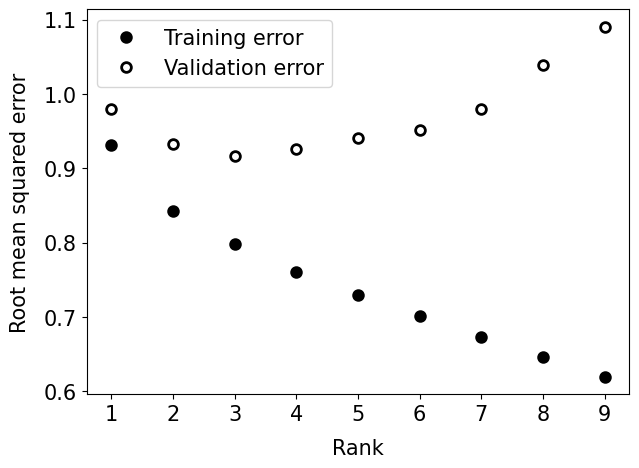

In [29]:
markersize = 7
plt.figure(figsize=(7,5))
plt.plot(ranks,train_error,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
                     markerfacecolor="black",label="Training error")
plt.plot(ranks,val_error,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
                     markerfacecolor="white",label="Validation error")
plt.ylabel('Root mean squared error',fontsize=font_size,labelpad=10)
plt.xlabel('Rank',fontsize=font_size,labelpad=10)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.legend(fontsize=font_size);

In [26]:
best_rank = 3
estimate = fit_low_rank_model(best_rank,rating_matrix_ini,train_ind,train_ratings,n_iter,convergence_thresh,verbose)
test_error = np.linalg.norm(test_ratings-estimate.flat[test_ind]) / np.sqrt(n_test)
print("Error of low-rank estimate: " + str(np.round(test_error,3)))

Converged after 35 iterations
Error of low-rank estimate: 0.887


In [27]:
# Simple, but effective, baseline: mean rating of each movie in the training set
mean_rating_estimate = np.tile(np.array([mean_rating_movie]).T,(1,n_users))
error_mean_rating = np.linalg.norm(test_ratings-mean_rating_estimate.flat[test_ind]) / np.sqrt(n_test)
print("Error of mean-movie estimate: " + str(np.round(error_mean_rating,3)))

Error of mean-movie estimate: 0.963


In [28]:
# Looking at the singular vectors of the low-rank model reveals some of the structure learned by the model
centered_estimate = estimate - np.mean(estimate)
u, s, vT = np.linalg.svd(centered_estimate, full_matrices=True)
factor_1 = u[:,0]
factor_2 = u[:,1]
factor_3 = u[:,2]

k=4
print("Factor 1")
sort_1 = np.argsort(factor_1)
print("\nMost negative")
for ind in range(k):
    print(movies[sort_1[ind]] + " " + str(np.round(factor_1[sort_1[ind]],3)))
print("\nMost positive")
for ind in range(1,k+1):
    print(movies[sort_1[-ind]] + " " + str(np.round(factor_1[sort_1[-ind]],3)))

print("\nFactor 2")
sort_2 = np.argsort(factor_2)
print("\nMost negative")
for ind in range(k):
    print(movies[sort_2[ind]] + " " + str(np.round(factor_2[sort_2[ind]],3)))
print("\nMost positive")
for ind in range(1,k+1):
    print(movies[sort_2[-ind]] + " " + str(np.round(factor_2[sort_2[-ind]],3)))

print("\nFactor 3")
sort_3 = np.argsort(factor_3)
print("\nMost negative")
for ind in range(k):
    print(movies[sort_3[ind]] + " " + str(np.round(factor_3[sort_3[ind]],3)))
print("\nMost positive")
for ind in range(1,k+1):
    print(movies[sort_3[-ind]] + " " + str(np.round(factor_3[sort_3[-ind]],3)))

Factor 1

Most negative
Casablanca (1942) -0.13
Godfather, The (1972) -0.115
One Flew Over the Cuckoo's Nest (1975) -0.102
Usual Suspects, The (1995) -0.102

Most positive
Volcano (1997) 0.286
Dante's Peak (1997) 0.278
Saint, The (1997) 0.243
Twister (1996) 0.236

Factor 2

Most negative
Raiders of the Lost Ark (1981) -0.168
Star Wars (1977) -0.166
Titanic (1997) -0.161
Empire Strikes Back, The (1980) -0.16

Most positive
Volcano (1997) 0.067
Evita (1996) 0.051
Murder at 1600 (1997) 0.043
Devil's Own, The (1997) 0.038

Factor 3

Most negative
Clockwork Orange, A (1971) -0.314
Leaving Las Vegas (1995) -0.303
Trainspotting (1996) -0.285
English Patient, The (1996) -0.251

Most positive
Return of the Jedi (1983) 0.125
Star Wars (1977) 0.121
Raiders of the Lost Ark (1981) 0.12
Titanic (1997) 0.112
